### Income Measures from Census

Typically annual data such as from the ACS and CPS ASEC

In [1]:
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

# Import tools for creating map
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon, Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize, LinearSegmentedColormap
plt.rc('font', family='Lato')

In [174]:
url = 'https://www.bls.gov/cpi/research-series/r-cpi-u-rs-allitems.xlsx'
df = pd.read_excel(url, header=5, index_col=0)
cpi = df['AVG'].dropna()
cpi.index = pd.to_datetime(cpi.index.astype('str')) + pd.DateOffset(months=6)
cpi.index.name = 'date'
cpi.name = 'value'
cpi.to_csv(data_dir / 'cpi_u_rs.csv', index_label='date')

In [179]:
# Download table PINC-08 1_1_1 for each year
base = 'https://www2.census.gov/programs-surveys/cps/tables/'
pinc8 = 'pinc08_1_1_1.xlsx'
cols = ['Total with income', 'Median income', 'Mean income']
pinc1 = 'pinc01_1_1_1.xlsx'
d = {}
d2 = {}
for year in range(2019, 2022):
    url1 = f'{base}pinc-08/{year+1}/{pinc8}'
    df = pd.read_excel(url1, header=9, index_col=0)
    df = df[cols].iloc[1:]
    d[year] = df.dropna()
    url2 = f'{base}pinc-01/{year+1}/{pinc1}'
    pop = pd.read_excel(url2, 'pinc01', index_col=None, 
                        usecols = 'B', header = 11, nrows=0)
    d2[year] = pop.columns.values[0]
di = {'Pop': d2, 'Inc': d}
pd.to_pickle(di,data_dir / 'pinc_temp.pickle')

In [96]:
yr1 = 2021
yr2 = 2019
cpi = pd.read_csv(data_dir / 'cpi_u_rs.csv', index_col='date', parse_dates=True)
pch = (cpi.loc[f'{yr1}-07-01'] / cpi.loc[f'{yr2}-07-01']).value

di = pd.read_pickle(data_dir / 'pinc_temp.pickle')
res = pd.concat(di['Inc'].values(), axis=1, keys=di['Inc'].keys())
res.index = res.index.str.replace('....Total', '\\textbf{Total}', regex=False)
res = res[res.index.str.contains('..', regex=False)==False]
res = res.rename({'SSI (Supplemental Security Income)': 'Supplemental Security Income', 
            'Financial assistance from outside the household': 'Outside financial assistance',
            'Other income, N.E.C.': 'Other'})
res = res.loc[:,res.columns.get_level_values(0).isin([yr1, yr2])]
res = res.reindex(columns=[yr1, yr2], level=0)
# Adjust for inflation
prvals = [(yr2, 'Median income'), (yr2, 'Mean income')]
res[prvals] = res[prvals] * pch
final = res.astype('int')

# Save version for download
res = res.applymap('{:,.0f}'.format)
res.index.name = ''
res.to_csv(data_dir / 'pinc08.csv', index_label='category')

# Store years separately for tex table
year1 = f'{res.columns[0][0]}'
year2 = f'{res.columns[3][0]}'
write_txt(text_dir / 'pinc_year1.txt', year1)
write_txt(text_dir / 'pinc_year2.txt', year2)

# Save version for tex table
res.droplevel(0, axis=1).to_csv(data_dir / 'pinc08.tex', sep='&', 
             line_terminator='\\\ ', quotechar=' ')

In [102]:
df = pd.DataFrame()
df[f'Mean {yr1}'] = final[(yr1, 'Mean income')]
df[f'Number {yr1}'] = final[(yr1, 'Total with income')] * 1000
df[f'Total {yr1}'] = df[f'Mean {yr1}'] * df[f'Number {yr1}']
df[f'Mean {yr2}'] = final[(yr2, 'Mean income')]
df[f'Number {yr2}'] = final[(yr2, 'Total with income')] * 1000
df[f'Total {yr2}'] = df[f'Mean {yr2}'] * df[f'Number {yr2}']
df['PctCh'] = ((df[f'Total {yr1}'] / df[f'Total {yr2}']) - 1) * 100
df['LvlCh'] = df[f'Total {yr1}'] - df[f'Total {yr2}']
df['LvlChP'] = (df[f'Number {yr1}'] * df[f'Mean {yr2}']) - df[f'Total {yr2}']
df['LvlChM'] = (df[f'Number {yr2}'] * df[f'Mean {yr1}']) - df[f'Total {yr2}']
df['ContribP'] = (df['LvlChP'] / df.loc['\\textbf{Total}', 'LvlCh']) * df.loc['\\textbf{Total}', 'PctCh']
df['ContribM'] = (df['LvlChM'] / df.loc['\\textbf{Total}', 'LvlCh']) * df.loc['\\textbf{Total}', 'PctCh']
df['Contrib'] = (df['LvlCh'] / df.loc['\\textbf{Total}', 'LvlCh']) * df.loc['\\textbf{Total}', 'PctCh']

# Determine six most prominent sources of change
df2 = df.drop(['\\textbf{Total}', 'Other'])
cats = (abs(pd.concat([df2['ContribP'], df2['ContribM'], df2['Contrib']]))
 .sort_values(ascending=False)
 .index.drop_duplicates(keep='first'))[:6]
# Top six used for bar chart
df.loc[cats, ['ContribP', 'ContribM']].to_csv(data_dir / 'pinc.csv', 
                                              index_label='Name')

# Save full version for download
(df[['Contrib', 'ContribP', 'ContribM']]
   .to_csv(data_dir / 'pinc_ch_contrib.csv', index_label='category'))

In [135]:
# Manual description for now
val = df.loc['\\textbf{Total}', 'PctCh']
valtext = value_text(val, 'increase_by', digits=2, adj='total')
text = (f'From {yr2} to {yr1}, aggregate pre-tax personal income {valtext}, '+
        f'after adjusting for changes in prices. Compared to {yr2}, fewer '+
        f'people received earnings from work, while mean earnings increased. '+
        f'Real income from pensions and retirement plans fell over the period. '+
        f'Unemployment compensation and property income contributed to the '+
        'overall growth in real income. ')
write_txt(text_dir / 'pi_ch_ann.txt', text)
print(text)

From 2019 to 2021, aggregate pre-tax personal income increased by a total of 0.55 percent, after adjusting for changes in prices. Compared to 2019, fewer people received earnings from work, while mean earnings increased. Real income from pensions and retirement plans fell over the period. Unemployment compensation and property income contributed to the overall growth in real income. 


### Median Household Income by State

In [2]:
# Uncomment below to retrieve data from API if needed
year = 2021
srs = 'S1901_C01_012E'
# url = (f'https://api.census.gov/data/{year}/acs/acs1/subject?'+
#       f'get=NAME,{srs}&for=state:*&key={census_key}')
# r = requests.get(url).json()
# df = (pd.DataFrame(r[1:], columns=r[0])
#        .set_index('NAME')
#        .astype({srs: 'int'}))

# # Retrieve US level data
# url2 = (f'https://api.census.gov/data/{year}/acs/acs1/subject?'+
#       f'get=NAME,S1901_C01_012E&for=us:1&key={census_key}')
# r2 = requests.get(url2).json()
# us = (pd.DataFrame(r2[1:], columns=r2[0])
#        .set_index('NAME')
#        .astype({srs: 'int'}))
# df2 = pd.concat([df, us])
# df2.to_csv(data_dir / 'median_hh_inc_state.csv', index_label='name')

# Retrieve locally stored data
df = pd.read_csv(data_dir / 'median_hh_inc_state.csv', index_col='name')
data = df[srs] / 1000
vmin = 40
vmax = 100
if (vmin > min(data.drop('Puerto Rico'))) or (vmax < max(data)):
    print('Check max and min boundaries')
step = 10
legend_ticks = np.arange(vmin, vmax + step, step).tolist()

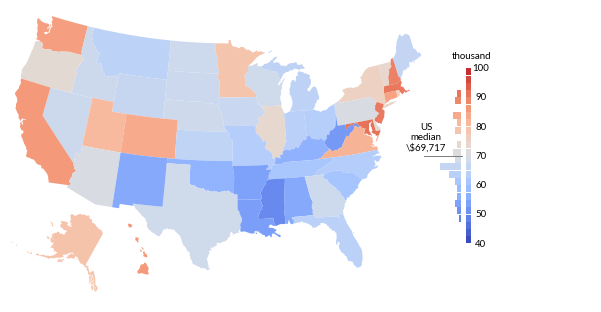

In [3]:
# Set map projection and boundaries
m = Basemap(llcrnrlon=-118, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

fig = plt.figure(figsize=(8.6,3.8))

m.drawmapboundary()
m.readshapefile('shapefiles/states', 'states', drawbounds=False) 

ax = plt.gca()
ax.axis('off')
    
# Assign income values to colors
cm = plt.cm.coolwarm
norm = Normalize(40, 100)

# Add states to map
for info, shape in zip(m.states_info, m.states):
    fc = cm(norm(data[info['STATE_NAME']]))
    # Alaska and Hawaii moved
    if info['STATE_NAME'] == 'Hawaii':
        shape = [(x + 5200000, y - 1400000) for x,y in shape]
    elif info['STATE_NAME'] == 'Alaska':
        shape = [(x*0.35 + 900000, y*0.35 - 1300000) for x,y in shape]
    ax.add_patch(Polygon(shape, fc=fc))

# Custom legend    
ax_inset = inset_axes(ax, width='-40%', height='60%', loc=7, borderpad=0.2)
for tick_label in legend_ticks:
    plt.text(0.66, norm(tick_label), tick_label, fontsize=7, 
             ha='center', va='center', transform=ax_inset.transAxes)
ax_inset.axis('off')

nbins = 25
for i in np.linspace(vmin,vmax,nbins):
    rect = Rectangle(xy=(0.72, norm(i)), width=0.03, height=(1/nbins), 
        fc=cm(norm(i)), ec=None)
    ax_inset.add_patch(rect)  
bins = pd.cut(data, np.linspace(vmin,vmax,nbins)).apply(lambda x: x.left)
res = data.groupby(bins).count()
for i, v in res.items():
    rect = Rectangle(xy=(0.78 + (v / 80), norm(i)), width= -(v / 80),
                     height=(1/(nbins)), fc=cm(norm(i)), ec=None)
    if v > 0:
        ax_inset.add_patch(rect) 

# US median noted on legend
line = Rectangle(xy=(1.02, norm(data['United States'])), width=-0.25,
                     height=0.005, fc='gray', ec='none')
ax_inset.add_patch(line)
# US total 
ust = f"\\\${data['United States'] * 1000:,.0f}"
plt.text(0.99, norm(data['United States']) + 0.11, f'US\nmedian\n{ust}', fontsize=7, 
             ha='center', va='center', transform=ax_inset.transAxes)  
        
# Text to note legend is in thousands        
plt.text(0.72, 1.07, 'thousand', fontsize=7, 
             ha='center', va='center', transform=ax_inset.transAxes)        
        
plt.savefig('../chartbook/data/hh_med_inc.pgf', bbox_inches='tight')

In [4]:
url = 'https://www.census.gov/library/publications/2022/acs/acsbr-011.html'
usmed = f"\${data['United States'] * 1000:,.0f}"

tmp = data.drop(['Puerto Rico', 'United States']).sort_values()
above_st = tmp[tmp > data['United States']]
above_no = len(above_st)
below_st = tmp[tmp < data['United States']]
below_no = len(below_st)
above = f'{above_no} states'
below = f'{below_no} states'
if 'District of Columbia' in above_st:
    above = f'{above_no - 1} states and the District of Columbia'
if 'District of Columbia' in below_st:
    below = f'{below_no - 1} states and the District of Columbia'

text1 = (f'Lastly, the Census Bureau \href{{{url}}}'+
         '{report} median household income by state, calculated using '+
         f'the American Community Survey. In {year}, the median US '+
         f'household income, using this measure, is {usmed}. In the '+
         f'same year, the median income in {above} is above the national '+
         f'median, and the median income in {below} is below the national '+
         'median.\n\n')
tmp = data.drop(['Puerto Rico', 'United States']).sort_values()
tmp = tmp.rename({'District of Columbia': 'the District of Columbia'}) * 1000
second = tmp.index[-2][0].upper() + tmp.index[-2][1:] # Capitalize
txt = {}
for i in [4, 5, 6, 7, 8, 9, 10]:
    txt[i] = f'{tmp.index[-i]} (\${tmp.iloc[-i]:,.0f})'
    if i == 10:
        txt[i] = f'and {txt[i]}'
othhigh = ', '.join([v for k,v in txt.items()])
txt2 = {}
for i in [1, 2, 3, 4, 5]:
    txt2[i] = f'{tmp.index[i]} (\${tmp.iloc[i]:,.0f})'
    if i == 5:
        txt2[i] = f'and {txt2[i]}'
othlow = ', '.join([v for k,v in txt2.items()])

pr = f'Median household income in Puerto Rico is \${data["Puerto Rico"]*1000:,.0f}. '
text2 = (f'In {year}, {tmp.index[-1]} tops the list, with a median household '+
         f'income of \${tmp.iloc[-1]:,.0f}. {second} has the second '+
         f'highest income (\${tmp.iloc[-2]:,.0f}), followed by '+
         f'{tmp.index[-3]} (\${tmp.iloc[-3]:,.0f}). Other high-income '+
         f'states include {othhigh}.\n\nThe state with the lowest {year} median '+
         f'household income is {tmp.index[0]} (\${tmp.iloc[0]:,.0f}), '+
         f'followed by {othlow}. {pr}')

text = text1 + text2
print(text)
write_txt(text_dir / 'med_hh_inc_state.txt', text)

Lastly, the Census Bureau \href{https://www.census.gov/library/publications/2022/acs/acsbr-011.html}{report} median household income by state, calculated using the American Community Survey. In 2021, the median US household income, using this measure, is \$69,717. In the same year, the median income in 19 states and the District of Columbia is above the national median, and the median income in 31 states is below the national median.

In 2021, Maryland tops the list, with a median household income of \$90,203. The District of Columbia has the second highest income (\$90,088), followed by Massachusetts (\$89,645). Other high-income states include New Jersey (\$89,296), New Hampshire (\$88,465), California (\$84,907), Hawaii (\$84,857), Washington (\$84,247), Connecticut (\$83,771), and Colorado (\$82,254).

The state with the lowest 2021 median household income is Mississippi (\$48,716), followed by West Virginia (\$51,248), Louisiana (\$52,087), Arkansas (\$52,528), Alabama (\$53,913),

In [ ]:
# Table made manually from combining PINC-09 from 2021 and 2020
df = (pd.read_csv('../data/pinc-09-2020-2019.csv', index_col='Name')
        .drop(['Wages and salary', 'Nonfarm self-employment']))
df['Mean2019'] = df['Mean2019'] * (381.2/376.5) #CPI=RS-U
years = [2020, 2019]
for year in years:
    df[f'Total{year}'] = df[f'Number{year}'] * df[f'Mean{year}']
    
df['PctCh'] = ((df['Total2020'] / df['Total2019']) - 1) * 100
df['LvlCh'] = df['Total2020'] - df['Total2019']
df['LvlChP'] = (df['Number2020'] * df['Mean2019']) - df['Total2019']
df['LvlChM'] = (df['Number2019'] * df['Mean2020']) - df['Total2019']
df['ContribP'] = (df['LvlChP'] / df.loc['Total', 'LvlCh']) * df.loc['Total', 'PctCh']
df['ContribM'] = (df['LvlChM'] / df.loc['Total', 'LvlCh']) * df.loc['Total', 'PctCh']
df['Contrib'] = (df['LvlCh'] / df.loc['Total', 'LvlCh']) * df.loc['Total', 'PctCh']

cats = ['Earnings', 'Unemployment compensation', 
        'Property income', 'Retirement income']
df.loc[cats, ['ContribP', 'ContribM']].to_csv(data_dir / 'pinc.csv', 
                                              index_label='Name')
val = df.loc['Total', 'PctCh']
valtext = value_text(val, 'increase_by')
text = (f'In {years[0]}, aggregate pre-tax personal income {valtext}')
write_txt(text_dir / 'pi_ch_ann.txt', text)
print(text)

In [ ]:
url15 = 'https://www2.census.gov/programs-surveys/cps/tables/pinc-08/2016/pinc08_1_1_1.xls'
url16 = 'https://www2.census.gov/programs-surveys/cps/tables/pinc-08/2017/pinc08_1_1_1.xls'
url17 = 'https://www2.census.gov/programs-surveys/cps/tables/pinc-08/2018/bridge/pinc08_1_1_1.xls'
url18 = 'https://www2.census.gov/programs-surveys/cps/tables/pinc-08/2019/pinc08_1_1_1.xls'
url19 = 'https://www2.census.gov/programs-surveys/cps/tables/pinc-08/2020/pinc08_1_1_1.xlsx'
url20 = 'https://www2.census.gov/programs-surveys/cps/tables/pinc-08/2021/pinc08_1_1_1.xlsx'
url21 = 'https://www2.census.gov/programs-surveys/cps/tables/pinc-08/2022/pinc08_1_1_1.xlsx'

In [139]:
# Download table PINC-08 1_1_1 for each year
base = 'https://www2.census.gov/programs-surveys/cps/tables/pinc-08/'
file = 'pinc08_1_1_1.xls'
cols1 = ['Total with income', 'Median income', 'Mean income']
cols2 = ['Total with Income', 'Median income', 'Mean income']
hdr1 = 9
hdr2 = 10
urls = {}
d = {}
for year in range(2018, 2022):
    bridge = 'bridge/' if year == 2017 else ''
    x = 'x' if year > 2018 else ''
    cols = cols1 if year > 2018 else cols2
    hdr = hdr2 if year in [2017, 2018] else hdr1
    url = f'{base}{year+1}/{bridge}{file}{x}'
    df = pd.read_excel(url, header=hdr, index_col=0)
    urls[year] = url
    df = df[cols].iloc[1:]
    if year < 2017:
        df = df.loc[:'Combination of Income Types:']
    df.index = df.index.str.replace('.', '', regex=False).str.lower()
#    df = df.rename({'Other Income, NEC': 'Other income, NEC'})
    d[year] = df.dropna()#.rename({'Total with Income': 'Total with income'}, 
                #        axis=1).dropna()